In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import env
# import wrangle

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# acquire & summarize

# 1

In [2]:
# SQL query 
sql = """
SELECT prop.*, 
       pred.logerror, 
       pred.transactiondate, 
       air.airconditioningdesc, 
       arch.architecturalstyledesc, 
       build.buildingclassdesc, 
       heat.heatingorsystemdesc, 
       landuse.propertylandusedesc, 
       story.storydesc, 
       construct.typeconstructiondesc 
FROM   properties_2017 prop  
       INNER JOIN (SELECT parcelid,
       					  logerror,
                          Max(transactiondate) transactiondate 
                   FROM   predictions_2017 
                   GROUP  BY parcelid, logerror) pred
               USING (parcelid) 
       LEFT JOIN airconditioningtype air USING (airconditioningtypeid) 
       LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid) 
       LEFT JOIN buildingclasstype build USING (buildingclasstypeid) 
       LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid) 
       LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid) 
       LEFT JOIN storytype story USING (storytypeid) 
       LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid) 
WHERE  prop.latitude IS NOT NULL 
       AND prop.longitude IS NOT NULL AND transactiondate <= '2017-12-31' 
"""

In [3]:
def get_db_url(database):
    from env import host, user, password
    url = f'mysql+pymysql://{user}:{password}@{host}/{database}'
    return url

In [4]:
# acquire zillow data using the query
def get_zillow(sql):
    url = get_db_url('zillow')
    zillow_df = pd.read_sql(sql, url)
    return zillow_df

In [5]:
# Save DF as csv locally

df = get_zillow(sql)
df.to_csv("zillow.csv")

In [6]:
# Code uploads DF into 

df = pd.read_csv("zillow.csv")
df.head(3)

,Unnamed: 0,id,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,censustractandblock,logerror,transactiondate,airconditioningdesc,architecturalstyledesc,buildingclassdesc,heatingorsystemdesc,propertylandusedesc,storydesc,typeconstructiondesc
0,0,1727539,14297519,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,6.059063e+13,0.025595,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
1,1,1387261,17052889,NaN,NaN,NaN,1.0,2.0,NaN,NaN,...,6.111001e+13,0.055619,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN
2,2,11677,14186244,NaN,NaN,NaN,2.0,3.0,NaN,NaN,...,6.059022e+13,0.005383,2017-01-01,NaN,NaN,NaN,NaN,Single Family Residential,NaN,NaN


# 2 
Summarize your data (summary stats, info, dtypes, shape, distributions, value_counts, etc.)

In [7]:
def summarize_data(data_frame):
    print('--------------------- Shape ---------------------')
    print(f"SHAPE: f{df.shape}")
    print('________________________________________________')
    print(df.head(3))
    print('________________________________________________')
    print('--------------------- Info ---------------------')
    print(df.info())
    print('________________________________________________')


    # Look at null values per colunm 
    print('--------------- Null Value Count --------------------')
    print(df.isnull().sum().sort_values(ascending = False)[:45])
    print('________________________________________________')

    
    # plot some distributions 
    print('--------------------- Visual Distributions ----------------------')
    plt.figure(figsize = (12,8))
    plt.subplot(221)
    plt.hist(df.bedroomcnt, bins = 10)
    plt.title('Bedrooms')

    plt.subplot(222)
    plt.hist(df.calculatedfinishedsquarefeet, bins = 100)
    plt.title('finished area')

    plt.subplot(223)
    plt.hist(df.logerror, bins = 100)
    plt.title('logerror')

    plt.subplot(224)
    plt.hist(df.taxvaluedollarcnt, bins = 100)
    plt.title('taxvaluedollarcnt')

    plt.tight_layout();


--------------------- Shape ---------------------
SHAPE: f(77574, 69)
________________________________________________
   Unnamed: 0       id  parcelid  airconditioningtypeid  \
0           0  1727539  14297519                    NaN   
1           1  1387261  17052889                    NaN   
2           2    11677  14186244                    NaN   

   architecturalstyletypeid  basementsqft  bathroomcnt  bedroomcnt  \
0                       NaN           NaN          3.5         4.0   
1                       NaN           NaN          1.0         2.0   
2                       NaN           NaN          2.0         3.0   

   buildingclasstypeid  buildingqualitytypeid  ...  censustractandblock  \
0                  NaN                    NaN  ...         6.059063e+13   
1                  NaN                    NaN  ...         6.111001e+13   
2                  NaN                    NaN  ...         6.059022e+13   

   logerror  transactiondate  airconditioningdesc  architectur

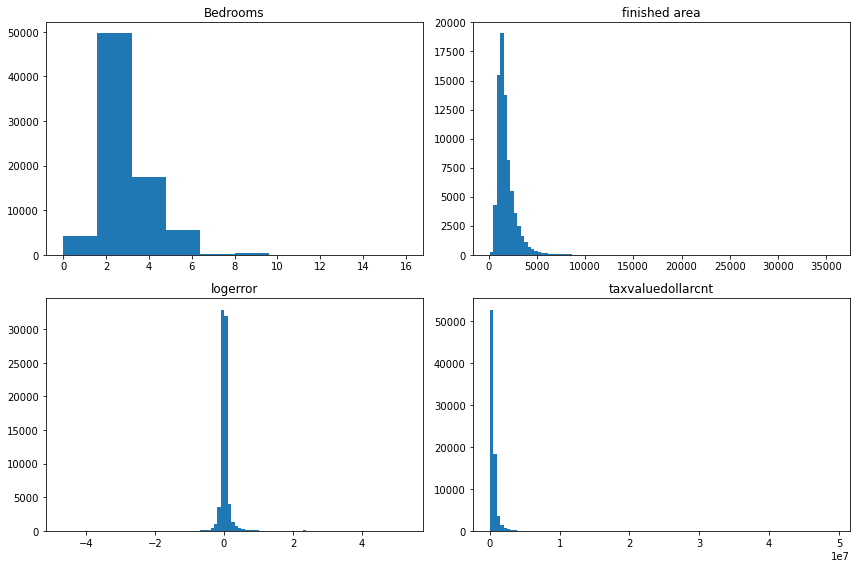

In [8]:
summarize_data(df)

# 3
Write a function that takes in a dataframe of observations and attributes and returns a dataframe where each row is an atttribute name, the first column is the number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute. Run the function and document takeaways from this on how you want to handle missing values.


In [9]:
# Count null values 
df.isnull().sum()

Unnamed: 0                      0
id                              0
parcelid                        0
airconditioningtypeid       52568
architecturalstyletypeid    77368
                            ...  
buildingclassdesc           77559
heatingorsystemdesc         28005
propertylandusedesc             0
storydesc                   77524
typeconstructiondesc        77352
Length: 69, dtype: int64

In [10]:
def nulls_by_col(df):
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    pct_missing = num_missing / rows
    cols_missing = pd.DataFrame({'number_missing_rows': num_missing, 'percent_rows_missing': pct_missing})
    return cols_missing

In [11]:
nulls_by_column = nulls_by_col(df)
nulls_by_column.sort_values(by="percent_rows_missing", ascending=False).head(50)

,number_missing_rows,percent_rows_missing
buildingclasstypeid,77559,0.999807
buildingclassdesc,77559,0.999807
finishedsquarefeet13,77532,0.999459
storytypeid,77524,0.999355
storydesc,77524,0.999355
basementsqft,77524,0.999355
yardbuildingsqft26,77504,0.999098
fireplaceflag,77402,0.997783
architecturalstyletypeid,77368,0.997344
architecturalstyledesc,77368,0.997344


# 4.
Write a function that takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, and number of rows with n columns missing. Run the function and document takeaways from this on how you want to handle missing values.

In [12]:
pd.DataFrame(df.isnull().sum(axis =1).value_counts()).reset_index()

,index,0
0,33,14817
1,34,13356
2,32,12606
3,31,9911
4,36,5793
5,29,5285
6,35,5163
7,37,3630
8,30,3465
9,38,1932


In [13]:
cols_missing = pd.DataFrame(df.isnull().sum(axis =1), columns = ['num_cols_missing']).reset_index().groupby('num_cols_missing')\
.count().reset_index().rename(columns = {'index': 'num_rows'})

cols_missing['pct_cols_missing'] = cols_missing.num_cols_missing/df.shape[1]
cols_missing.head()

,num_cols_missing,num_rows,pct_cols_missing
0,23,2,0.333333
1,24,13,0.347826
2,25,24,0.362319
3,26,65,0.376812
4,27,316,0.391304


In [14]:
def cols_missing(df):
    cols_missing_df = pd.DataFrame(df.isnull().sum(axis =1), columns = ['num_cols_missing']).reset_index()\
    .groupby('num_cols_missing').count().reset_index().\
    rename(columns = {'index': 'num_rows' })
    cols_missing_df['pct_cols_missing'] = cols_missing_df.num_cols_missing/df.shape[1]
    return cols_missing_df

In [15]:
# call new DF and sort by pc_col_missing
cols_missing(df).sort_values(by = ['pct_cols_missing'], ascending = False)

,num_cols_missing,num_rows,pct_cols_missing
25,48,3,0.695652
24,47,3,0.681159
23,46,5,0.666667
22,45,50,0.652174
21,44,79,0.637681
20,43,29,0.623188
19,42,26,0.608696
18,41,29,0.594203
17,40,230,0.579710
16,39,285,0.565217


# Prepare

## 1.
Remove any properties that are likely to be something other than single unit properties. (e.g. no duplexes, no land/lot, ...). There are multiple ways to estimate that a property is a single unit, and there is not a single "right" answer. But for this exercise, do not purely filter by unitcnt as we did previously. Add some new logic that will reduce the number of properties that are falsely removed. You might want to use # bedrooms, square feet, unit type or the like to then identify those with unitcnt not defined.

In [16]:
df.shape

(77574, 69)

In [17]:
# look at value counts for 'unitcnt'

df.unitcnt.value_counts(dropna = False)


1.0      47412
NaN      26872
2.0       2031
4.0        726
3.0        529
42.0         1
237.0        1
45.0         1
6.0          1
Name: unitcnt, dtype: int64

In [18]:
# Restrict df to only properties that meet single unit criteria

single_use = [261, 262, 263, 264, 266, 268, 273, 276, 279]
df = df[df.propertylandusetypeid.isin(single_use)]
    
    
# Restrict df to only those properties with at least 1 bath & bed and >350 sqft area
df = df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0) & ((df.unitcnt<=1)|df.unitcnt.isnull()) & (df.calculatedfinishedsquarefeet>350)]

In [19]:
# check # of columns and rows left
df.shape

(71355, 69)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71355 entries, 0 to 77573
Data columns (total 69 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    71355 non-null  int64  
 1   id                            71355 non-null  int64  
 2   parcelid                      71355 non-null  int64  
 3   airconditioningtypeid         22901 non-null  float64
 4   architecturalstyletypeid      206 non-null    float64
 5   basementsqft                  47 non-null     float64
 6   bathroomcnt                   71355 non-null  float64
 7   bedroomcnt                    71355 non-null  float64
 8   buildingclasstypeid           0 non-null      float64
 9   buildingqualitytypeid         44841 non-null  float64
 10  calculatedbathnbr             71340 non-null  float64
 11  decktypeid                    586 non-null    float64
 12  finishedfloor1squarefeet      5674 non-null   float64
 13  c

# 2.
Create a function that will drop rows or columns based on the percent of values that are missing: handle_missing_values(df, prop_required_column, prop_required_row).

- The input:
    - A dataframe
    - A number between 0 and 1 that represents the proportion, for each column, of rows with non-missing values required to keep the column. i.e. if prop_required_column = .6, then you are requiring a column to have at least 60% of values not-NA (no more than 40% missing). 

- The output:
    - The dataframe with the columns and rows dropped as indicated. Be sure to drop the columns prior to the rows in your function.

- hint:
    - Look up the dropna documentation.
    - You will want to compute a threshold from your input values (prop_required) and total number of rows or columns.
    - Make use of inplace, i.e. inplace=True/False.


In [21]:
# look at number of nulls for each column
df.isnull().sum()


Unnamed: 0                      0
id                              0
parcelid                        0
airconditioningtypeid       48454
architecturalstyletypeid    71149
                            ...  
buildingclassdesc           71355
heatingorsystemdesc         24943
propertylandusedesc             0
storydesc                   71308
typeconstructiondesc        71133
Length: 69, dtype: int64

In [22]:
# Sekect columns that we don't need

cols_to_remove = ['id',
       'calculatedbathnbr', 'finishedsquarefeet12', 'fullbathcnt', 'heatingorsystemtypeid'
       ,'propertycountylandusecode', 'propertylandusetypeid','propertyzoningdesc', 
        'censustractandblock', 'propertylandusedesc', 'unitcnt']

In [23]:
def remove_columns(df, cols_to_remove):  
    df = df.drop(columns=cols_to_remove)
    return df

In [24]:
# use the function defined above to remove the columns not needed:

df = remove_columns(df, cols_to_remove)

In [25]:
# How many nulls do we still have?

df.isnull().sum()

Unnamed: 0                          0
parcelid                            0
airconditioningtypeid           48454
architecturalstyletypeid        71149
basementsqft                    71308
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             71355
buildingqualitytypeid           26514
decktypeid                      70769
finishedfloor1squarefeet        65681
calculatedfinishedsquarefeet        0
finishedsquarefeet13            71355
finishedsquarefeet15            71346
finishedsquarefeet50            65681
finishedsquarefeet6             71197
fips                                0
fireplacecnt                    63271
garagecarcnt                    46409
garagetotalsqft                 46409
hashottuborspa                  69817
latitude                            0
longitude                           0
lotsizesquarefeet                8034
poolcnt                         55691
poolsizesum                     70491
pooltypeid10

In [26]:
# Let's look at heatingorsystemdesc value counts

df.heatingorsystemdesc.value_counts(dropna = False)

Central       31357
NaN           24943
Floor/Wall    13229
Yes             850
Forced air      775
Solar           101
None             60
Radiant          23
Baseboard        13
Gravity           3
Heat Pump         1
Name: heatingorsystemdesc, dtype: int64

In [27]:
# how many records per county 

df.fips.value_counts()

6037.0    45320
6059.0    20289
6111.0     5746
Name: fips, dtype: int64

In [28]:
# how many missing values by county?
df[df.fips == 6111].heatingorsystemdesc.value_counts(dropna = False)

NaN    5746
Name: heatingorsystemdesc, dtype: int64

In [29]:
# I assume that since this is Southern CA, 'null' probably means 'None' for heating system
# W will drop heatingorsystemdesc

df.drop(columns = 'heatingorsystemdesc', inplace = True)


In [30]:
# buildingqualitytypeid
# Overall assessment of condition of the building from 
# low number = best quality
# higher numbers = worse quality

df.buildingqualitytypeid.value_counts(dropna = False)

NaN     26514
8.0     13404
6.0     12673
4.0      8226
7.0      5505
9.0      2113
5.0      1499
11.0      846
10.0      301
3.0       149
12.0      113
1.0         9
2.0         3
Name: buildingqualitytypeid, dtype: int64

In [31]:
df[df.fips == 6059].buildingqualitytypeid.value_counts(dropna = False)


NaN    20289
Name: buildingqualitytypeid, dtype: int64

In [32]:
# what is the median value of buildingqualitytypeid?

# df.buildingqualitytypeid.median()

# what is the median value of buildingqualitytypeid?

# df.buildingqualitytypeid.median()

In [33]:
# I should just drop the buildingqualitytypeid column for now.

df.drop(columns = 'buildingqualitytypeid', inplace = True)

In [34]:
df.isnull().sum()

Unnamed: 0                          0
parcelid                            0
airconditioningtypeid           48454
architecturalstyletypeid        71149
basementsqft                    71308
bathroomcnt                         0
bedroomcnt                          0
buildingclasstypeid             71355
decktypeid                      70769
finishedfloor1squarefeet        65681
calculatedfinishedsquarefeet        0
finishedsquarefeet13            71355
finishedsquarefeet15            71346
finishedsquarefeet50            65681
finishedsquarefeet6             71197
fips                                0
fireplacecnt                    63271
garagecarcnt                    46409
garagetotalsqft                 46409
hashottuborspa                  69817
latitude                            0
longitude                           0
lotsizesquarefeet                8034
poolcnt                         55691
poolsizesum                     70491
pooltypeid10                    70891
pooltypeid2 